In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import h5py
from astropy.time import Time
import numpy as np
import glob
import pandas as pd
import re
from datetime import datetime
import dask.dataframe as dd
import torch

In [10]:
from torch.utils import data

In [115]:
from matplotlib import cm

## Helper functions 

Define some important helper functions to be used later

In [2]:
import sys
sys.path.append('../')
from dataloader import SuperMAGIAGADataset,OMNIDataset,ShpericalHarmonicsDatasetBucketized
from utils.data_utils import get_omni_data,get_iaga_data_as_list
from utils.splitter import generate_indices
from metricgen import EventMetrics,Generate_metrics
from Forecaster import Forecaster,Generate_complete_weimer_forecast,Generate_weimer_forecast
from models.geoeffectivenet import *
import pickle
torch.set_default_dtype(torch.float64)  # this is important else it will overflow

In [3]:
import matplotlib.colors

class SqueezedNorm(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, mid=0, s1=2, s2=2, clip=False):
        self.vmin = vmin # minimum value
        self.mid  = mid  # middle value
        self.vmax = vmax # maximum value
        self.s1=s1; self.s2=s2
        f = lambda x, zero,vmax,s: np.abs((x-zero)/(vmax-zero))**(1./s)*0.5
        self.g = lambda x, zero,vmin,vmax, s1,s2: f(x,zero,vmax,s1)*(x>=zero) - \
                                             f(x,zero,vmin,s2)*(x<zero)+0.5
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        r = self.g(value, self.mid,self.vmin,self.vmax, self.s1,self.s2)
        return np.ma.masked_array(r)

# Load hyperparameters

In [7]:
future_length = 1 #WAS DEFAULT IN THE CODE
past_omni_length = 120
nmax = 20
targets = ["dbe_nez", "dbn_nez"]
lag = 30
learning_rate = 5e-3
batch_size = 8500
omni_resolution = 1
dropout_prob = 0.7
l2reg = 5e-5
n_hidden = 8
loss = 'MAE'
basepath = f"../Best/Reg_Faster_FULL_{loss}_{past_omni_length}_{nmax}_{n_hidden}_{learning_rate*1e6}_{l2reg*1e6}/"

# load scaler to unstandardize data
scalers = pickle.load(open(f"{basepath}scalers.p", "rb"))
_mean, _std = scalers["supermag"]

dbe_mean, dbn_mean = _mean
dbe_std, dbn_std = _std

# Load data

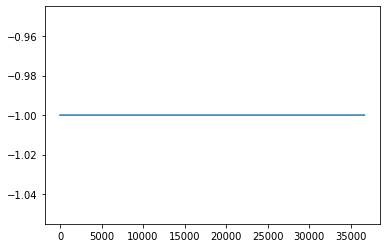

In [83]:
plt.plot(wiemer_idx[:-1,0]-wiemer_idx[1:,0])

In [8]:
yearlist = list(np.arange(2011,2018).astype(int))
supermag_data = SuperMAGIAGADataset(*get_iaga_data_as_list(base="../full_data_panos/iaga/",year=yearlist))
yearlist = list(np.arange(2011,2018).astype(str))
omni_data = OMNIDataset(get_omni_data("../data_local/omni/sw_data.h5", year=yearlist))

yearlist = list(np.arange(2011,2018).astype(int))
train_idx,test_idx,val_idx,wiemer_idx = generate_indices(base="../full_data_panos/iaga/",year=yearlist,
                                                    LENGTH=past_omni_length,LAG=lag,
                                                    omni_path="../data_local/omni/sw_data.h5",
                                                    weimer_path="../data_local/weimer/")
train_idx = np.asarray(train_idx)
val_idx = np.asarray(val_idx)
test_idx = np.asarray(test_idx)
wiemer_idx = np.asarray(wiemer_idx)

train_ds = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,train_idx,
        f107_dataset="../data_local/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=None,training_batch=True,nmax=nmax)
print("Train dataloader defined....")
val_ds = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,val_idx,
        f107_dataset="../data_local/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=train_ds.scaler,training_batch=False,nmax=nmax)
print("Val dataloader defined....")
wiemer_ds = ShpericalHarmonicsDatasetBucketized(supermag_data,omni_data,wiemer_idx,
        f107_dataset="../data_local/f107.npz",targets=targets,past_omni_length=past_omni_length,
        past_supermag_length=1,future_length=future_length,lag=lag,zero_omni=False,
        zero_supermag=False,scaler=train_ds.scaler,training_batch=False,nmax=nmax)
print("Weimer dataloader defined....")

loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 1827.74it/s]


loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.19s/it]


loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [00:28<00:00,  2.37s/it]


loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [00:28<00:00,  2.34s/it]


loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.63s/it]


loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [00:53<00:00,  4.43s/it]


loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [00:53<00:00,  4.45s/it]


loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [00:50<00:00,  4.24s/it]


loading from path ../full_data_panos/iaga/ /
loading supermag iaga data...


100%|█████████████████████████████████████████████████████████████████████████| 108/108 [00:00<00:00, 2293.39it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 642.81it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 660.06it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 658.02it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 666.94it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 658.42it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 666.91it/s]


loading supermag iaga data...


100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 651.64it/s]


testing 2011
testing 2012
testing 2013
testing 2014
testing 2015
testing 2016
testing 2017
testing done
extracting f107
learning scaler....
NOTE: Since the dataset is large, we take mean across only a limited set of samples due to memory constraint
Train dataloader defined....
extracting f107
using existing scaler
Val dataloader defined....
extracting f107
using existing scaler
Weimer dataloader defined....


In [11]:
wiemer_loader = data.DataLoader(wiemer_ds, batch_size=batch_size, shuffle=False, num_workers=12)
# train_loader = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=12)
val_loader = data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=12)

In [12]:
targets_idx = [np.where(train_ds.supermag_features == target)[0][0] for target in targets]

## Load Model

In [188]:
model = NeuralRNNWiemer.load_from_checkpoint(f'{basepath}/epoch=8-step=3077.ckpt', strict=False, 
                                                 past_omni_length=past_omni_length,
                                                 future_length=future_length,
                                                 supermag_features=wiemer_ds.supermag_features,
                                                 omni_features=wiemer_ds.omni_features,
                                                 nmax=nmax,omni_resolution=omni_resolution,
                                                 targets_idx=targets_idx,learning_rate = learning_rate,
                                                 l2reg=l2reg,
                                                 dropout_prob=dropout_prob,
                                                 n_hidden=n_hidden,
                                                 loss=loss)

Constructing spherical harmonics functions


In [189]:
model = model.cuda().double()

## Generate Forecasts 

## Load the Weimer forecasts

In [18]:
weimer = {}
with h5py.File(f"../data_local/weimer/TimeStepGeomagnetic_20150317_1min.h5", "r") as f:
    for k in f.keys():
        weimer[k] = f.get(k)[:]

weimer_times_unix = Time(weimer['JDTIMES'],format='jd').to_value('unix')

## FDL model forecasts

In [25]:
dbe_index = np.where(wiemer_ds.supermag_features == 'dbe_nez')[0][0]
dbn_index = np.where(wiemer_ds.supermag_features == 'dbn_nez')[0][0]
print(dbn_index,dbe_index)
target_index = {'dbe':dbe_index,'dbn':dbn_index}

3 2


In [190]:
Predictions,Targets,All_times_coeff,Date_arr,MLT_sup_all,Mcolat_sup_all = Forecaster(wiemer_loader,model,dbe_mean,dbe_std,dbn_mean,dbn_std,target_index)

## Weimer forecasts on supermag

In [191]:
36670-2370

34300

In [192]:
start = np.argmin(np.abs(Date_arr['dbe']-weimer_times_unix[0]))
end = np.argmin(np.abs(Date_arr['dbe']-weimer_times_unix[-1]))

In [193]:
weimer['DB'][:,1].shape,MLT_sup_all['dbe'].shape,Mcolat_sup_all['dbe'].shape, Predictions['dbe'].shape

((3361, 100, 96), (36670, 175), (36670, 175), (36670, 175))

### Get the Weimer basis

In [194]:
print(weimer.keys())
weimer_mlt = np.deg2rad(90-weimer['GRIDMLTS']*360/24.0)
weimer_colat = np.deg2rad(90 - weimer['GRIDLATS'])
weimer_basis = basis_matrix(nmax ,weimer_mlt, weimer_colat)
weimer_shape = weimer['GRIDMLTS'].shape


dict_keys(['DB', 'GRIDLATS', 'GRIDMLTS', 'JDTIMES', 'LATITUDES', 'MLTVALS'])


In [195]:
Mcolat_sup_all['dbe'][start:end+1].shape

(3361, 175)

In [59]:
prediction_weimer_dbn = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,0],
                                                          MLT_sup_all['dbn'][start:end+1],Mcolat_sup_all['dbn'][start:end+1])
prediction_weimer_dbe = Generate_complete_weimer_forecast(weimer_mlt[0,:],weimer_colat[:,0],weimer['DB'][:,1],
                                                          MLT_sup_all['dbe'][start:end+1],Mcolat_sup_all['dbe'][start:end+1])

### Generate metrics

In [196]:
Targets['dbe'].shape,Predictions['dbe'].shape

((36670, 175), (36670, 175))

In [197]:
fdl_metrics_dbe = Generate_metrics(Targets['dbe'][start:end+1],Predictions['dbe'][start:end+1])
fdl_metrics_dbn = Generate_metrics(Targets['dbn'][start:end+1],Predictions['dbn'][start:end+1])

weimer_metrics_dbe = Generate_metrics(Targets['dbe'][start:end+1],prediction_weimer_dbn)
weimer_metrics_dbn = Generate_metrics(Targets['dbn'][start:end+1],prediction_weimer_dbe)

In [198]:
print(f"FDL dbe:{fdl_metrics_dbe}")
print(f"Weimer dbe:{weimer_metrics_dbe}")
print("--------------------")
print(f"FDL dbn: {fdl_metrics_dbn}")
print(f"Weimer dbn: {weimer_metrics_dbn}")

FDL dbe:{'mse': 102.39346417149645, 'mae': 61.35754693006334, 'r2': -0.33871114441913613}
Weimer dbe:{'mse': 179.97566133543347, 'mae': 105.56028778458173, 'r2': -2.5664643415948865}
--------------------
FDL dbn: {'mse': 175.10305338151605, 'mae': 104.64229261644822, 'r2': -1.5466198411467709}
Weimer dbn: {'mse': 195.52745684537453, 'mae': 121.48001443086898, 'r2': -0.6127816990403404}


In [200]:
eventmets_fdl = EventMetrics(Targets['dbe'][start:end+1],Targets['dbn'][start:end+1],Predictions['dbe'][start:end+1],Predictions['dbn'][start:end+1])
eventmets_weimer = EventMetrics(Targets['dbe'][start:end+1],Targets['dbn'][start:end+1],prediction_weimer_dbe,prediction_weimer_dbn)

(20, 1)
(20, 1)
(20, 1)
(20, 1)


In [201]:
for thresh in eventmets_fdl.keys():
  print(f"Threshold: {thresh}")
  for k in eventmets_fdl[thresh].keys():
    print(f"FDL {k}:{np.nanmean(eventmets_fdl[thresh][k])}+/-{np.nanstd(eventmets_fdl[thresh][k])}")
    print(f"Weimer {k}:{np.nanmean(eventmets_weimer[thresh][k])}+/-{np.nanstd(eventmets_weimer[thresh][k])}")
    print("------------")
  print("******************************************")

Threshold: 0.3
FDL pod:0.6769751366632129+/-0.2699463102646453
Weimer pod:0.11311719272561865+/-0.07603967419557534
------------
FDL pofd:0.5603766745604986+/-0.31920959150666367
Weimer pofd:0.03824080345220604+/-0.03846569239030079
------------
FDL hss:0.03992950161000571+/-0.152853696286174
Weimer hss:0.06248037549558295+/-0.07174652281368216
------------
******************************************
Threshold: 0.7
FDL pod:0.34557150541172377+/-0.27584390438710876
Weimer pod:0.021686170580661777+/-0.03580651639345623
------------
FDL pofd:0.27081311361588206+/-0.24481915363964832
Weimer pofd:0.009506345860124592+/-0.011388334984788815
------------
FDL hss:-0.0015686125121960543+/-0.1035219661617398
Weimer hss:0.01198263948827784+/-0.04783418833881415
------------
******************************************
Threshold: 1.1
FDL pod:0.147506517922284+/-0.16322192933014887
Weimer pod:0.009160459087537357+/-0.02723385060989045
------------
FDL pofd:0.13879307011465702+/-0.15057694897360696
Wei

## Check plots

In [66]:
Targets['dbe'].shape,Predictions['dbe'].shape,prediction_weimer_dbn.shape

((36670, 175), (36670, 175), (3361, 175))

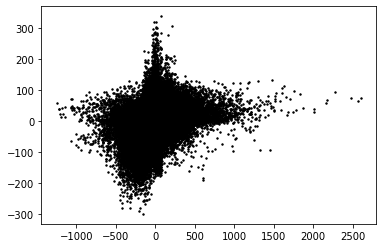

In [68]:
plt.scatter(Targets['dbe'][start:end+1].ravel(),Predictions['dbe'][start:end+1].ravel(),s=2.0,c='k')
# plt.scatter(Targets['dbe'].ravel(),prediction_weimer_dbe.ravel(),s=2.0,c='b')

Text(0.5, 0, 'time')

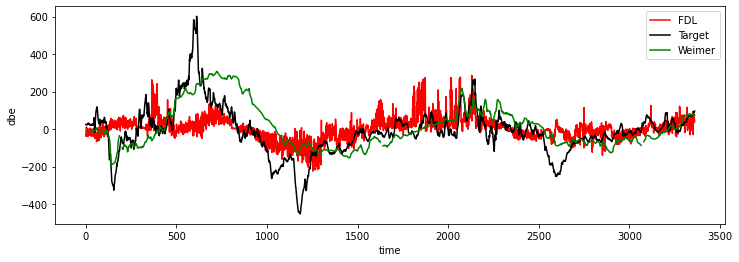

In [202]:
plt.figure(figsize=(12,4))
plt.plot(Predictions['dbe'][start:end+1][:,100],'r',label='FDL')
plt.plot(Targets['dbe'][start:end+1][:,100],'k',label='Target')
plt.plot(prediction_weimer_dbe[:,100],'g',label='Weimer')
plt.ylabel("dbe")
plt.legend(loc='best')
plt.xlabel("time")

Text(0, 0.5, 'dbn pred')

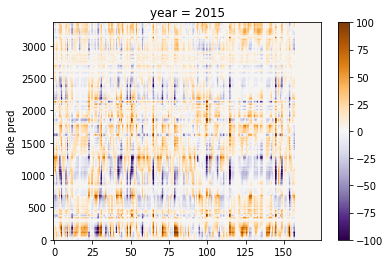

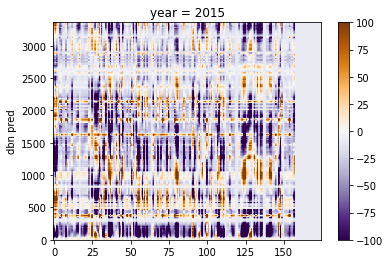

In [203]:
plt.imshow(Predictions['dbe'][start:end+1],cmap='PuOr_r',origin='lower',aspect='auto',clim=(-100,100))
plt.colorbar()
plt.title(f"year = 2015")
plt.ylabel("dbe pred")
plt.figure()
plt.imshow(Predictions['dbn'][start:end+1],cmap='PuOr_r',origin='lower',aspect='auto',clim=(-100,100))
plt.colorbar()
plt.title(f"year = 2015")
plt.ylabel("dbn pred")

In [204]:
prediction_weimer_dbn[:,130]

array([nan, nan, nan, ..., nan, nan, nan])

Text(0.5, 0, 'time')

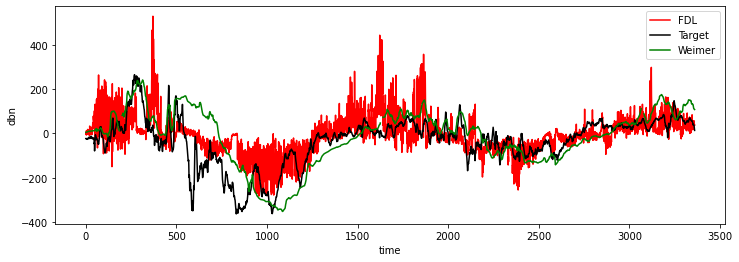

In [205]:
plt.figure(figsize=(12,4))
plt.plot(Predictions['dbn'][start:end+1][:,100],'r',label='FDL')
plt.plot(Targets['dbn'][start:end+1][:,100],'k',label='Target')
plt.plot(prediction_weimer_dbn[:,100],'g',label='Weimer')
plt.ylabel("dbn")
plt.legend(loc='best')
plt.xlabel("time")

In [85]:
All_times_coeff['dbn'].shape

(36670, 882)

## FDL forecast on weimer grid

In [206]:
weimer_predictions_gif = {'dbe':[],'dbn':[]}
fdl_on_weimergrid_gif = {'dbe':[],'dbn':[]}

fdl_on_weimergrid_gif['dbn'] = np.einsum('bij,lj->bil',weimer_basis,All_times_coeff['dbn'])
fdl_on_weimergrid_gif['dbe'] = np.einsum('bij,lj->bil',weimer_basis,All_times_coeff['dbe'])

fdl_on_weimergrid_gif['dbn'] = fdl_on_weimergrid_gif['dbn']*dbn_std + dbn_mean
fdl_on_weimergrid_gif['dbe'] = fdl_on_weimergrid_gif['dbe']*dbe_std + dbe_mean

weimer_predictions_gif['dbn'] = weimer['DB'][:, 0]
weimer_predictions_gif['dbe'] = weimer['DB'][:, 1]

print(fdl_on_weimergrid_gif['dbn'].shape,weimer_predictions_gif['dbn'].shape)


(100, 96, 36670) (3361, 100, 96)


In [207]:
weimer_basis.shape,All_times_coeff['dbn'].shape

((100, 96, 882), (36670, 882))

/tmp/ipykernel_424722/1151928150.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c1=ax1.pcolormesh(theta,phi,dbH ,cmap=cmap,norm=norm)
/tmp/ipykernel_424722/1151928150.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


Text(0.5, 0, 'Horizontal magnetic field perturbation ($\\delta\\mathrm{B}_{\\mathrm{H}}$)')

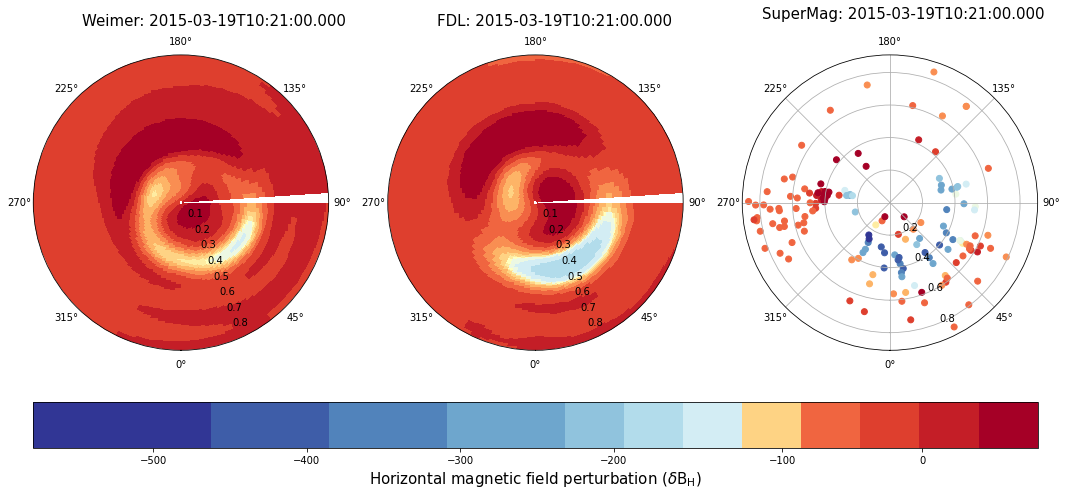

In [210]:
k = 'dbn'
fig1 = plt.figure(figsize=(18,8))
gs = fig1.add_gridspec(8, 3)

camera = Camera(fig1)
theta = weimer_mlt 
phi = weimer_colat 
cmap=cm.get_cmap("RdYlBu_r",17)
ax1 = fig1.add_subplot(gs[:-1,0], projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(gs[:-1,1], projection='polar')
ax2.set_theta_offset(-np.pi/2)
ax3 = fig1.add_subplot(gs[:-1,2], projection='polar')
ax3.set_theta_offset(-np.pi/2)
cax = fig1.add_subplot(gs[-1,:])
time_ind = -100
d = weimer['JDTIMES'][time_ind]

dt = Time(d,format='jd').to_value("fits")
dbH = Targets[k][start:end+1][time_ind] #np.sqrt(np.square(Targets['dbn'][start:end+1][time_ind])+np.square(Targets['dbe'][start:end+1][time_ind]))
maxval=np.nanmax(dbH)
minval=np.nanmin(dbH)
norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=np.nanmean(dbH), s1=2, s2=2)

dbH = weimer_predictions_gif[k][time_ind]# np.sqrt(np.square(weimer_predictions_gif['dbe'][time_ind])+np.square(weimer_predictions_gif['dbn'][time_ind]))
c1=ax1.pcolormesh(theta,phi,dbH ,cmap=cmap,norm=norm)
ax1.text(3.65,1.2,f"Weimer: {dt}",fontsize=15)

dbH = fdl_on_weimergrid_gif[k][:,:,start:end+1][...,time_ind] #np.sqrt(np.square(fdl_on_weimergrid_gif['dbe'][:,:,start:end+1][...,time_ind])+np.square(fdl_on_weimergrid_gif['dbn'][:,:,start:end+1][...,time_ind]))
c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)  
ax2.text(3.65,1.2,f"FDL: {dt}",fontsize=15)

dbH = Targets[k][start:end+1][time_ind] #np.sqrt(np.square(Targets['dbe'][start:end+1][time_ind])+np.square(Targets['dbn'][start:end+1][time_ind]))
c3=ax3.scatter(MLT_sup_all[k][start:end+1][time_ind],Mcolat_sup_all[k][start:end+1][time_ind], c=dbH,cmap=cmap,norm=norm)
ax3.text(3.75,1.38,f"SuperMag: {dt}",fontsize=15)

fig1.colorbar(c3, cax=cax,orientation='horizontal')
cax.set_xlabel(r'Horizontal magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{H}}$)',fontsize=15)

In [184]:
Targets[k].shape

(36670, 175)

In [96]:
from celluloid import Camera

/tmp/ipykernel_424722/2519122214.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)


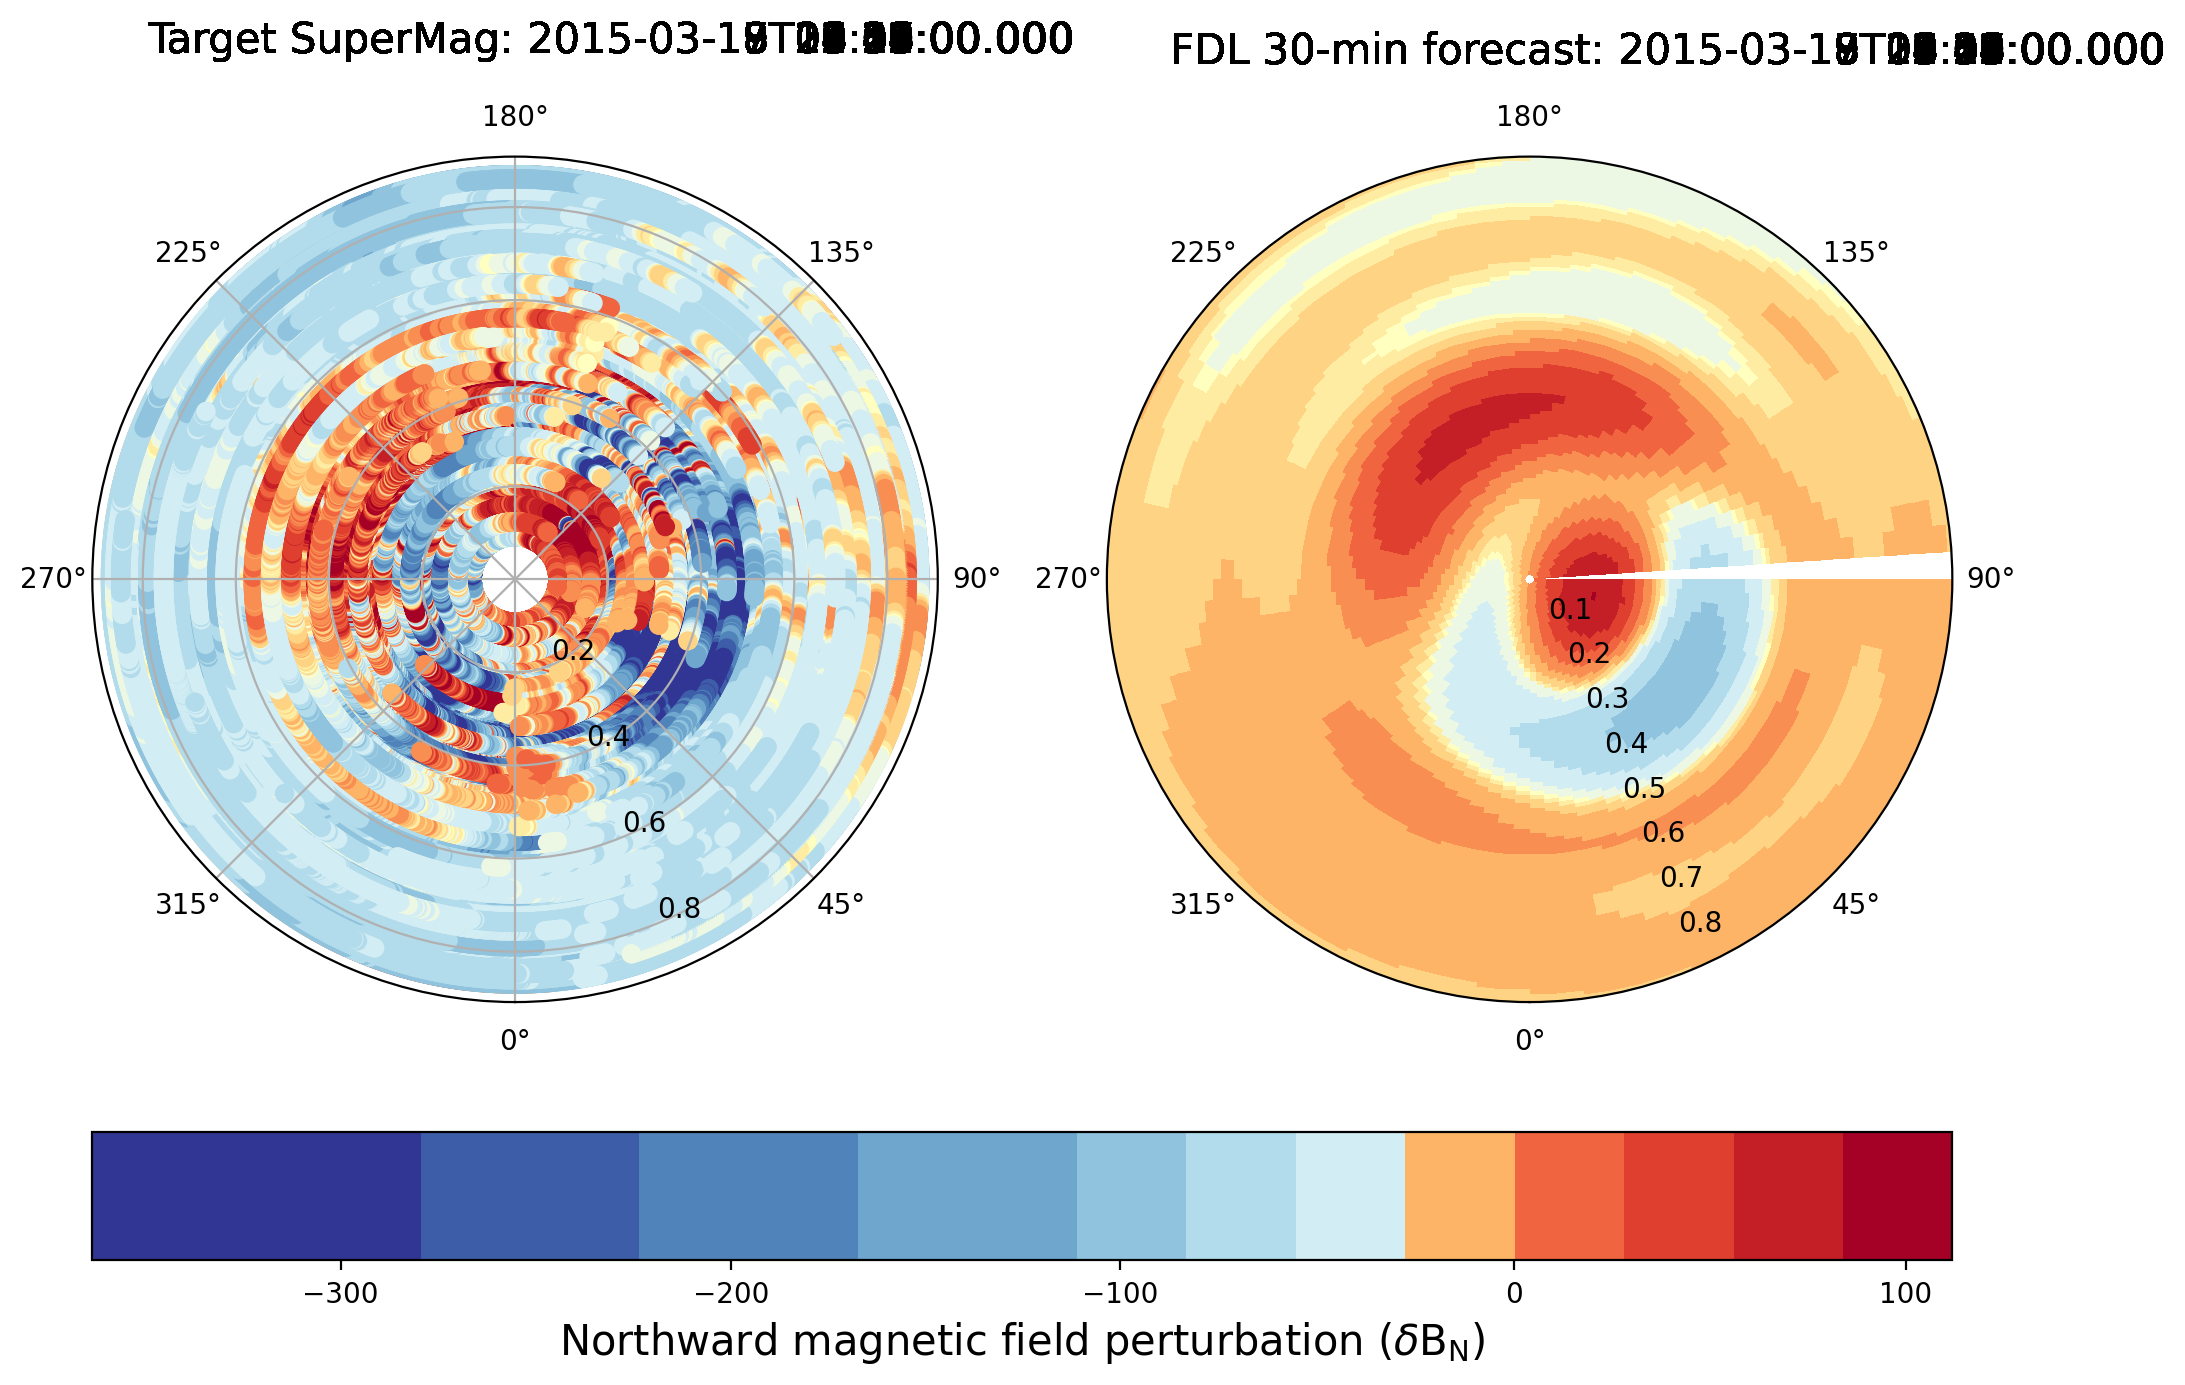

In [217]:
k = 'dbn'
f = 1
fig1 = plt.figure(figsize=(12*f,8*f),dpi=200)
gs = fig1.add_gridspec(8, 2)

camera = Camera(fig1)
theta = weimer_mlt 
phi = weimer_colat 
cmap=cm.get_cmap("RdYlBu_r",17)
ax1 = fig1.add_subplot(gs[:-1,0], projection='polar')
ax1.set_theta_offset(-np.pi/2)
ax2 = fig1.add_subplot(gs[:-1,1], projection='polar')
ax2.set_theta_offset(-np.pi/2)
# ax3 = fig1.add_subplot(gs[:-1,2], projection='polar')
# ax3.set_theta_offset(-np.pi/2)
cax = fig1.add_subplot(gs[-1,:])

dbH2 = Targets[k][start:end+1] #np.sqrt(np.square(Targets['dbe'][:,:,start:end+1])+np.square(Targets['dbn'][:,:,start:end+1]))

maxval = np.nanpercentile(dbH2,95)
minval = np.nanpercentile(dbH2,5)
norm=SqueezedNorm(vmin=minval, vmax=maxval, mid=np.nanmean(dbH), s1=2, s2=2)
for time_ind,d in enumerate(weimer['JDTIMES'][500:]):
    dt = Time(d,format='jd').to_value("fits")
#     dbH = np.sqrt(np.square(weimer_predictions_gif['dbe'][time_ind])+np.square(weimer_predictions_gif['dbn'][time_ind]))
#     c1=ax1.pcolormesh(theta,phi,dbH ,cmap=cmap,norm=norm)
#     ax1.text(3.65*f,1.2*f,f"Nowcast fitting : {dt}",fontsize=15*f)

    dbH = fdl_on_weimergrid_gif[k][:,:,start:end+1][...,time_ind] #np.sqrt(np.square(fdl_on_weimergrid_gif['dbe'][:,:,start:end+1][...,time_ind])+np.square(fdl_on_weimergrid_gif['dbn'][:,:,start:end+1][...,time_ind]))
    c2=ax2.pcolormesh(theta,phi, dbH,cmap=cmap,norm=norm)  
    ax2.text(3.75*f,1.3*f,f"FDL 30-min forecast: {dt}",fontsize=15*f)

    dbH = Targets[k][start:end+1][time_ind] #np.sqrt(np.square(Targets['dbe'][start:end+1][time_ind])+np.square(Targets['dbn'][start:end+1][time_ind]))
    c3=ax1.scatter(MLT_sup_all[k][start:end+1][time_ind],Mcolat_sup_all[k][start:end+1][time_ind], c=dbH,cmap=cmap,norm=norm,s=36*f)
    ax1.text(3.75*f,1.38*f,f"Target SuperMag: {dt}",fontsize=15*f)
    fig1.colorbar(c2, cax=cax,orientation='horizontal')
    cax.set_xlabel(r'Northward magnetic field perturbation ($\delta\mathrm{B}_{\mathrm{N}}$)',fontsize=15)
    camera.snap()

In [218]:
from IPython.display import HTML
animation = camera.animate()
# HTML(animation.to_html5_video())
# animation.save('dbH.mp4',bitrate=-1)

In [219]:
animation.save('dbH2.mp4')

## Check lag between solar wind and supermag

In [221]:
wiemer_idx.shape

(36670, 2)

In [233]:
tmpsg = supermag_data.data[wiemer_idx[0,0]:wiemer_idx[-1,-1]]
tmpom = omni_data.data.values[wiemer_idx[0,0]:wiemer_idx[-1,-1]]

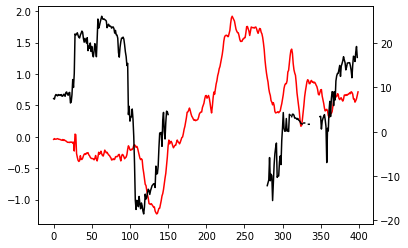

In [250]:
plt.figure()
ax=plt.subplot(1,1,1)
ax.plot(tmpsg[2900:3300,10,2],'r')
ax2=ax.twinx()
ax2.plot(tmpom[2900:3300,2],'k')

In [240]:
omni_data.data.columnsumns

Index(['bx', 'by', 'bz', 'vx', 'vy', 'vz', 'density', 'psw', 'temperature',
       'xgse', 'ygse', 'zgse', 'clock_angle'],
      dtype='object')